# Sistemas de Recomendación - Content-Based 
Beatriz Cárdaba y Sara Bengoechea

- Librerías
- Data Set
- Teoría
- Movie Description Based Recommender: 
    - Definición algortimo
    - Pueba de algoritmo
- Metadata Based Recommender: 
    - Definición algortimo
    - Pueba de algoritmo


### Librerías

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud, STOPWORDS
import ast
import plotly
import plotly.offline as py
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

### Data set Utilizado:
Importamos los data set que se va a utilizar para este sistema de recomendación:
 - Movies: nos dará datos genereles de las películas.
 - credits: nos facilita datos del casting

In [4]:
# cargamos los metadata de movies

movies = pd.read_csv("../data/01_raw/movies_metadata.csv")

/opt/anaconda3/envs/rec_sys_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
credits = pd.read_csv("../data/01_raw/credits.csv")
credits['id']= credits['id'].astype(str) # pasamos id a tipo string ya el numero es identificativo cono un DNI

In [6]:
movies = movies.merge(credits,on='id') # unimos las dos tablas importadas para tener la info de credits en la tabla movies

In [7]:
movies.dtypes # visulaizamos todas las columnas y el tipo de datos

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
cast                      object
crew                      object
dtype: object

## 1.	Filtrado por contenido

Mediante el filtrado por contenido se recomienda al usuario elementos que al propio usuario le hayan gustado previamente. Por ejemplo, si a alguien le gusta una película concreta, entonces se recomendará al usuario películas del mismo género o trama similar.

El sistema de recomendación funciona mediante dos tipos de vectores:

- Vector de perfil ('Profile vector'): un vector que contiene el comportamiento anterior del usuario, es decir, las películas que le gustaron o no le gustaron al usuario y las calificaciones que le dio.
- Vector de elemento ('Item vector'): contiene los detalles de cada elemento, por ejemplo, para la película almacenará género, reparto, director, etc.


Posteriormente halla la similitud del coseno ('Cosine similarity'), es decir, el coseno del ángulo entre el vector de perfil y el vector de elemento.

Este valor varía entre -1 y 1. Según la distancia del coseno, los elementos se ordenan en orden descendente.

Otros sustitutos de la similitud del coseno:

- 'TOP-N approach': se recomiendan las 10 mejores películas.

- 'RATING SCALE APPROACH': Se establece un límite y se recomiendan todos los elementos por encima de ese límite.

- DISTANCIA EUCLIDEA: Los elementos similares se encuentran muy cerca unos de otros, esto calcula la distancia euclidiana entre elementos y, en función de la distancia, se pueden recomendar elementos.

- CORRELACIÓN DE PEARSON: Habla en términos de correlación. A mayor correlación, mayor similitud.


Para nuestro sistema de recomendación usaremos la similitud del coseno que matemáticamente se define de la siguiente manera: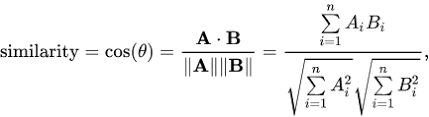

### Movie Description Based Recommender

Para comenzar tenemos que tratar los valores nulos

In [8]:
movies.overview = movies.overview.fillna("")

Ya que se trata de una cadena de texto (stream), debemos procesar dicho texto.

Mediante la función ``TfidfVectorizer()`` convierte una colección de 'raw documents' en una matriz de características TF-IDF. Para comprender esta matriz, comprender los siguientes términos:

- 'Term frequency' (TF) es la frecuencia relativa de una palabra en un documento y se da como (número de veces que aparece un término/ términos totales). 
- 'Inverse Document Frequency' (IDF) es el recuento relativo de documentos que contienen el término en cuestión como logaritmo de (número de documentos / documentos con término). 

La importancia general de cada palabra para los documentos en los que aparecen es igual a TF * IDF. En resumen:

- TF = (term instances/total instances)

- IDF = log(number of documents/documents with term).

__Importancia de cada palabra = TF * IDF__


Por último, mediante el parámetro stop_words = 'english' determinamos que es una lista integrada de palabras vacías para el idioma inglés.

In [9]:
tfidf = TfidfVectorizer(stop_words='english') 

Creamos dicha matriz y observamos sus dimensiones. Cada fila representa una película y cada columna es una palabra de su resumen. De esta manera reducimos la importancia de las palabras que ocurren frecuentemente en los resúmenes de las películas y, por tanto, reducimos su importancia a la hora de calcular su similitud.

In [10]:
tfidf_matrix = tfidf.fit_transform(movies['overview'])
tfidf_matrix.shape

(45538, 75827)


Con esta matriz ya podemos calcular la similaridad. En nuestro caso, lo calcularemos mediante 'Cosine Similarity'.

Dado que hemos utilizado el vectorizador TF-IDF, calcular el producto escalar nos dará directamente la puntuación de similitud del coseno. Por lo tanto, usaremos linear_kernel () de sklearn en lugar de cosine_similarities () ya que es más rápido.


In [11]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Creamos una serie llamada 'índices' que contiene los títulos de las películas.

In [12]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

Creamos la función que nos recomiende según la descripción de la película

In [13]:
def get_recommendations_description(title, k):
    index = indices[title] # El título en el índice
    
    similarity = list(enumerate(cosine_sim[index]))# Creamos una lista llamada similarty en 
    #la que aplicamos el grado de similaridad (array cosine_sim) al cada título (que está en el índice)
    
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True) # # ordenamos por 
    # similaridad en orden descendente. 
    
    similarity = similarity[1:k] # para que muestre el número de recomendaciones que escojamos
    
    movie_indices = [i[0] for i in similarity] 
    
    return movies['title'].iloc[movie_indices]# Para que devuelva los títulos con mayor cosine similarity

Comprobamos que funciona:

In [14]:
get_recommendations_description('X-Men', 10)

32331                              Superman
20883                    Hulk vs. Wolverine
23542    Mission: Impossible - Rogue Nation
13692              X-Men Origins: Wolverine
6224                                     X2
30147                               Holiday
21369                         The Wolverine
746                             The Phantom
38089                              Sharkman
Name: title, dtype: object

### Metadata Based Recommender

La calidad de un recomendador depende en gran medida de los metadatos que utiliza. A continuación construiremos un recomendador basado en los siguientes metadatos: 
- Los 3 actores principales.
- El director.
- Los géneros relacionados.
- Las palabras clave de la trama de la película.

De las columnas 'cast', 'crew' y 'keywords', debemos extraer los tres actores más importantes, el director y las palabras clave asociadas con esa película. Actualmente nuestros datos están presentes en forma de listas "en cadena" y necesitaremos convertirlos en una estructura segura y utilizable.

Para comenzar debemos importar el fichero que contiene las palabras clave de cada película para posteriormente introducirlo como columna en nuestra base de datos.

In [15]:
keywords = pd.read_csv("../data/01_raw/keywords.csv")
keywords.head(3)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


In [16]:
# cambiamos el id a int para poder hacer un merge entre keywords y movies
keywords['id']= keywords['id'].astype(str)

In [17]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  object
 1   keywords  46419 non-null  object
dtypes: object(2)
memory usage: 725.4+ KB


Juntamos keywords y movies y comprobamos que aparece la columna llamada keywords.

In [18]:
movies = movies.merge(keywords, on='id')
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


Creamos una lista con el nombre de las cuatro columnas que necesitamos para crear el algoritmo, para posteriormente crear el objeto 'movies[feature]' con la información que necesitaremos

In [20]:
features = ['cast', 'crew', 'keywords', 'genres'] # lista

In [21]:
# Convertimos la lista en un objeto
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)
    

In [22]:
movies[features].head(3)

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."


Examinamos el contenido de crew.

In [23]:
movies.crew[0][0] # crew de la primera línea

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

Creamos una función para poder obtener el director de cada película

In [24]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

Añadimos una columna con el nombre del director a nuestro database 'movies'

In [25]:
movies['director'] = movies['crew'].apply(get_director)

In [26]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch


Mediante la siguiente función transformamos la columna Cast para quedarte solo con los tres primeros nombres del cast ya que serán los actores más importantes.

In [27]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names

Ahora en features ya no está la columna de crew, ya que previamente obtuvimos la información que queríamos (el director). Más adelante incluiremos la columna del director.

In [28]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [29]:
movies[features][:5] 

,cast,keywords,genres
0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"
3,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"
4,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence]",[Comedy]


Limpiamos los datos convirtiendo todo en minúsculas mediante la función ``clean_data()``

In [30]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

En features introducimos la columna de director y aplicamos la función recién creada.

In [31]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [32]:
movies[features].head()

,cast,keywords,director,genres
0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy]",johnlasseter,"[animation, comedy, family]"
1,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,"[adventure, fantasy, family]"
2,"[waltermatthau, jacklemmon, ann-margret]","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,"[romance, comedy]"
3,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...",forestwhitaker,"[comedy, drama, romance]"
4,"[stevemartin, dianekeaton, martinshort]","[baby, midlifecrisis, confidence]",charlesshyer,[comedy]


Con la siguiente función creamos una colección de los metadatos conteniendo las 4 columnas anteriores pero como string (movies['metadata_collection']), que posteriormente introduciremos en el "vectorizer". 

In [33]:
# Creating collection of metadata as string which is to be fed to the vectorizer
def metadata_collection(x):
#     colec = " "
    return  ' '.join (x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])


In [34]:
movies['metadata_collection'] = movies.apply(metadata_collection, axis=1)

Visualizamos la primera fila

In [35]:
movies['metadata_collection'][0]

'jealousy toy boy tomhanks timallen donrickles johnlasseter animation comedy family'

Con la función ``CountVectorizer()`` convertimos documentos de texto en un vector que recuenta los términos (palabras de nuestro string). Mediante el parámetro stop_words = 'english' determinamos que es una lista integrada de palabras vacías para el idioma inglés.

In [37]:
count = CountVectorizer(stop_words='english')

Convertimos el stream movies['metadata_collection'] en vector de recuentos de términos llamado 'count_matrix'.

In [38]:
count_matrix = count.fit_transform(movies['metadata_collection'])

Tenemos un vector con 346294 elementos.

In [39]:
count_matrix

<46628x73881 sparse matrix of type '<class 'numpy.int64'>'
	with 346294 stored elements in Compressed Sparse Row format>

Medianate ``cosine_similarity()`` obtenemos el coseno de los ángulos de vectores, de tal manera, que cuanto mayor sea el coseno mayor es la similaridad entre los vectores.

In [40]:
cosine_sim = cosine_similarity(count_matrix, count_matrix) # array que contiene el grado de similaridad de los vectores

In [42]:
movies = movies.reset_index() # quitamos índice de movies

In [43]:
# creamos una serie llamada índice con el título de las películas
indices = pd.Series(movies.index, index=movies['title']) 

In [44]:
movies.head(3)

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,metadata_collection
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,fishing bestfriend duringcreditsstinger walter...


Creamos función para recomendaciones por metadata

In [45]:
def get_recommendations_metadata(title, k):
    index = indices[title] # El título en el índice
    
    similarity = list(enumerate(cosine_sim[index])) # Creamos una lista llamada similarty en 
    #la que aplicamos el grado de similaridad (array cosine_sim) al cada título (que está en el índice)
    
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True) # ordenamos por 
    # similaridad en orden descendente. 
    
    similarity = similarity[1:k] # para que muestre el número de recomendaciones que escojamos
    
    movie_indices = [i[0] for i in similarity] 
    
    return movies['title'].iloc[movie_indices] # Para que devuelva los títulos con mayor cosine similarity

Comprobamos que funciona:

In [46]:
get_recommendations_metadata("The Godfather", 5)

1934     The Godfather: Part III
1199      The Godfather: Part II
15609            The Rain People
18940                  Last Exit
Name: title, dtype: object

In [47]:
get_recommendations_metadata("X-Men", 5)

6264                        X2
11068    X-Men: The Last Stand
15324               Iron Man 2
21009       Hulk vs. Wolverine
Name: title, dtype: object

In [48]:
get_recommendations_metadata("Mean Girls", 5)

6513                            Freaky Friday
7232     Confessions of a Teenage Drama Queen
8190                              The Cookout
22574                               The Guide
Name: title, dtype: object

__Bibliografía__
- https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data
- https://github.com/Invince11/IMBD-Movie-Recommendation-System/blob/master/Movie-Recommendation.ipynb
- https://www.kaggle.com/rounakbanik/movie-recommender-systems
- https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada